In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_test
import seis_invert
import seis_prior
#import seis_nn
import cupy as cp
import seis_diagnostics
import seis_forward
import seis_forward2

F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


In [2]:
data=kgs.load_all_train_data()
d = data[8011]
print(d.family)

Style_A


In [3]:
# importlib.reload(seis_prior)
# importlib.reload(seis_diagnostics)
# importlib.reload(seis_invert)
# kgs.profiling=False
# kgs.debugging_mode = 0
# seis_forward2.profiling=False
# seis_forward2.reset_profile()

# model = seis_invert.InversionModel()
# model.state = 1
# model.method = 'L-BFGS-B'
# model.maxiter = 5000
# model.prior = seis_prior.SquaredExponential()


# model.prior.basis_functions();
# w = cp.linalg.eigvalsh(model.prior.P)   
# plt.figure()
# plt.semilogy(cp.asnumpy(cp.abs(w)))

maxiter wrong


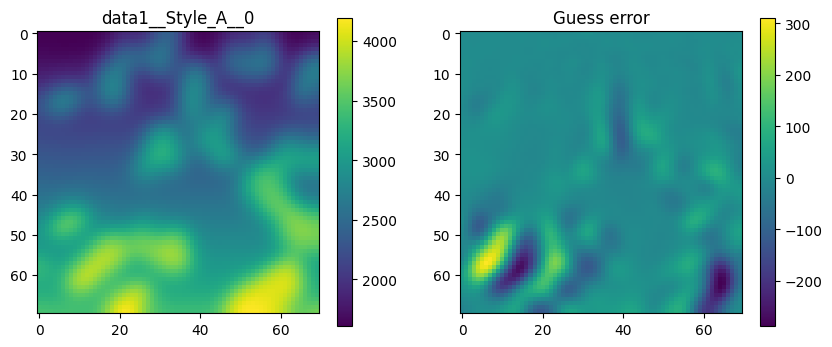

diag 1.9656961788752064e-05


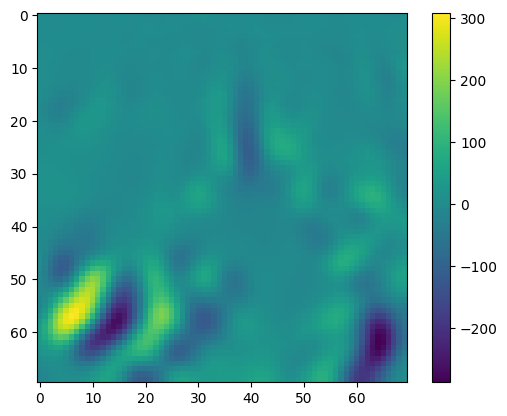

False True
(4901, 1073)
0.00043503787194721277
6.678962482771419e-12
gn 0.008755746334479142
151.79834849426587
(1073,)
(1073, 1)
(1073,)
(1073,)
(1073,)
(1073,)
(1073,)
(1073,)
(1073,)
(1073,)
(1073,)
(1073,)
(1073,)
(1073,)


NameError: name 'res2' is not defined

In [5]:
importlib.reload(seis_prior)
importlib.reload(seis_diagnostics)
importlib.reload(seis_invert)
importlib.reload(seis_forward)
kgs.profiling=False
seis_invert.profiling=False
kgs.debugging_mode = 0
seis_forward2.profiling=False
seis_forward2.reset_profile()

# transform back on, history size to infinite, maxiter down
model = seis_invert.InversionModel()
model.state = 1
model.maxiter = 1000
print('maxiter wrong')
model.history_size = 10000
model.prior = seis_prior.SquaredExponential()
model.prior.transform = True
model.prior.svd_cutoff = 1.
model.prior.λ = 10**-11
model.do_gn=True
model.show_convergence=True
#model.prior.basis_functions()
#KK = cp.pad(model.prior.K, ((0, 1), (0, 1)), mode='constant', constant_values=0)
#KK[-1,-1] = 10000.
#U,s,_=cp.linalg.svd(model.prior.K,compute_uv=True)
#model.prec_matrix = (U@cp.diag(cp.sqrt(s)))
#model.prec_matrix = cp.pad(model.prec_matrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)
#model.prec_matrix = cp.diag(cp.sqrt(1/cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))))
#plt.figure()
#plt.imshow(cp.asnumpy(cp.log(cp.reshape(cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))[:-1],(70,70)))/cp.log(10)))
#plt.colorbar()
#model.prior.use_full=True

do_which_list = [False,False,True]

def param_func(model,value):
    if value==1:
        #model.prec_matrix = cp.diag(cp.sqrt(1/cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))))
        model.prior.transform=False
        model.prior.basis_functions()
        
        #KK = cp.pad(model.prior.K, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        #KK[-1,-1] = 10000.
        #U,s,_=cp.linalg.svd(model.prior.P+(1/model.prior.λ)*cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))[:-1],compute_uv=True)
        U,s,_=cp.linalg.svd(cp.diag(cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ')))[:-1],compute_uv=True)
        model.prec_matrix = (U@cp.diag(1/cp.sqrt(s)))
        model.prec_matrix = cp.pad(model.prec_matrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        model.prec_matrix[-1,-1] = 1.
        #model.prec_matrix = cp.diag(cp.sqrt(1/cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))))
        # U,s,_=cp.linalg.svd(model.prior.K,compute_uv=True)
        # model.prec_matrix = (U@cp.diag(cp.sqrt(s)))
        # model.prec_matrix = cp.pad(model.prec_matrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        # model.prec_matrix[-1,-1] = 1.
    #model.prior.transform = value
    if value==2:
        #model.prec_matrix = cp.diag(cp.sqrt(1/cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))))
        model.prior.transform=False
        #model.prior.basis_functions()
        
        #KK = cp.pad(model.prior.K, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        #KK[-1,-1] = 10000.
        #U,s,_=cp.linalg.svd(model.prior.P+(1/model.prior.λ)*cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))[:-1],compute_uv=True)
        #U,s,_=cp.linalg.svd(cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))[:-1],compute_uv=True)
        #model.prec_matrix = (U@cp.diag(1/cp.sqrt(s)))
        #model.prec_matrix = cp.pad(model.prec_matrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        #model.prec_matrix[-1,-1] = 1.
        #model.prec_matrix = cp.diag(cp.sqrt(1/cp.diag(kgs.dill_load(kgs.temp_dir + 'JTJ'))))
        # U,s,_=cp.linalg.svd(model.prior.K,compute_uv=True)
        # model.prec_matrix = (U@cp.diag(cp.sqrt(s)))
        # model.prec_matrix = cp.pad(model.prec_matrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)
        # model.prec_matrix[-1,-1] = 1.
    return model
param_values = [0]
param_name = "prec"


for d in data[8000:8001]:
    results = seis_diagnostics.do_diagnostics_run(d, model, do_which_list, param_func, param_values, param_name, help_fac=0.)

In [ ]:
%debug

In [ ]:
seis_forward2.show_profile(1)